In [1]:
import math
import sympy as sp
from sympy.utilities.lambdify import lambdify
import numpy as np
import matplotlib.pyplot as plt

import openrtdynamics2.lang as dy
import openrtdynamics2.py_execute as dyexe
import openrtdynamics2.targets as tg

from vehicle_lib.vehicle_lib import *


# Kinematic bicycle model

The dynamic system equations are given by

$
\dot X
=
f(x,y,\psi)
=
\begin{pmatrix} 
  \dot x \\
  \dot y \\
  \dot \psi
\end{pmatrix}
=
\begin{pmatrix} 
  v \cos( \delta + \psi) \\
  v \sin( \delta + \psi) \\
  v / l_r \sin( \delta ), \\
\end{pmatrix}
$

with the state vector

$ X = [ x, y, \psi ]^T $.


Herein, $x$ and $y$ denote the coordinates of the vehicle front axle in cartesian space and $\psi$ the vehicle body orientation angle. The system inputs are the steering angle $\delta$ and the vehicle velocity $v$. Finally, the parameter $l_r$ denotes the wheelbase, which is the length in-between front and rear axle.




In [2]:
x, y, v, delta, psi, l_r, T_s, n = sp.symbols('x y v delta psi l_r T_s n')

x_dot   = v * sp.cos( delta + psi )
y_dot   = v * sp.sin( delta + psi )
psi_dot = v / l_r * sp.sin( delta )

# system function f
f = sp.Matrix([ x_dot, y_dot, psi_dot ])

# state vector
X_bic = sp.Matrix( [ x, y, psi ])

# input vector
U_bic = sp.Matrix( [ delta, v ])

In [3]:
f

Matrix([
[v*cos(delta + psi)],
[v*sin(delta + psi)],
[  v*sin(delta)/l_r]])

# Discretization of the continunous model

By applying Euler-forward discretization

$ {X}[k+1] = \underbrace{ {X}[k] + T_s  \dot{X} }_{f_{dscr}} $,

the continuous system is time-discretized with the sampling time $T_s$ yielding the discrete system funtion $f_{dscr}$.


In [4]:
# apply Euler forward
f_dscr = sp.Matrix( [x,y,psi]) + T_s * f

In [5]:
f_dscr

Matrix([
[T_s*v*cos(delta + psi) + x],
[T_s*v*sin(delta + psi) + y],
[T_s*v*sin(delta)/l_r + psi]])

# Analytically compute the Jacobian matrices

A linearization of the non-linear system function around a dynamic set point is calculated by deriving the jacobian matrices w.r.t. the state vector $X$ and each system input $\delta$ and $v$:

continuous case 
$
  A = \frac{ \partial f }{ \partial X},
  \qquad
  B = \frac{ \partial f }{ \partial [ \delta, v ]^T },  
$

discrete-time case
$
  A_{dscr} = \frac{ \partial f_{dscr} }{ \partial X},
  \qquad
  B_{dscr} = \frac{ \partial f_{dscr} }{ \partial [ \delta, v ]^T },  
$

In [6]:
# continuous system matrices
A = f.jacobian(X_bic)
B = f.jacobian(U_bic)

# discrete system matrices
A_dscr = f_dscr.jacobian(X_bic)
B_dscr = f_dscr.jacobian(U_bic)

In [7]:
A_dscr

Matrix([
[1, 0, -T_s*v*sin(delta + psi)],
[0, 1,  T_s*v*cos(delta + psi)],
[0, 0,                       1]])

In [8]:
B_dscr

Matrix([
[-T_s*v*sin(delta + psi), T_s*cos(delta + psi)],
[ T_s*v*cos(delta + psi), T_s*sin(delta + psi)],
[   T_s*v*cos(delta)/l_r,   T_s*sin(delta)/l_r]])

# Create functions that generate the matrices A, B, and the system function f

Create python functions with which the symbolically dervied matrices and system function can be evaluated. 

In [9]:
variables = (T_s,l_r, x,y,psi,v,delta)

array2mat = [{'ImmutableDenseMatrix': np.matrix}, 'numpy']

A_dscr_fn = lambdify( variables, A_dscr, modules=array2mat)
B_dscr_fn = lambdify( variables, B_dscr, modules=array2mat)
f_dscr_fn = lambdify( variables, f_dscr, modules=array2mat)


In [10]:
A_dscr_fn(0.01, 3.0, 0.1,0.2,0.4,10,0.1)

matrix([[ 1.        ,  0.        , -0.04794255],
        [ 0.        ,  1.        ,  0.08775826],
        [ 0.        ,  0.        ,  1.        ]])

In [11]:
B_dscr_fn(0.01, 3.0, 0.1,0.2,0.4,10,0.1)

matrix([[-0.04794255,  0.00877583],
        [ 0.08775826,  0.00479426],
        [ 0.03316681,  0.00033278]])

In [12]:
f_dscr_fn(0.01, 3.0, 0.1,0.2,0.4,10,0.1)

matrix([[0.18775826],
        [0.24794255],
        [0.40332778]])

# Run a simulation to generate test data

Set-up a simulation of a vehicle (bicycle model). The steering rate $\dot\delta$ is the input and integrated to obtain the steering angle $\delta$. A picewise constant (step signal) is applied to the input $\dot\delta$. The velocity $v$ is set to a constant value.

In [13]:
system = dy.enter_system()

velocity               = dy.system_input( dy.DataTypeFloat64(1), name='velocity_',             default_value=5.0,    value_range=[0, 25],     title="vehicle velocity [m/s]")

s1                     = dy.system_input( dy.DataTypeFloat64(1), name='s1',                    default_value=0.0,    value_range=[-0.05, 0.05], title="steering rate 1 [rad/s]")
s2                     = dy.system_input( dy.DataTypeFloat64(1), name='s2',                    default_value=0.0,    value_range=[-0.05, 0.05], title="steering rate 2 [rad/s]")
s3                     = dy.system_input( dy.DataTypeFloat64(1), name='s3',                    default_value=0.0,    value_range=[-0.05, 0.05], title="steering rate 3 [rad/s]")
s4                     = dy.system_input( dy.DataTypeFloat64(1), name='s4',                    default_value=0.0,    value_range=[-0.05, 0.05], title="steering rate 4 [rad/s]")
s5                     = dy.system_input( dy.DataTypeFloat64(1), name='s5',                    default_value=0.0,    value_range=[-0.05, 0.05], title="steering rate 5 [rad/s]")

initial_steering       = dy.system_input( dy.DataTypeFloat64(1), name='initial_steering',      default_value=-0.0,   value_range=[-40, 40],   title="initial steering angle [degrees]")       * dy.float64(math.pi / 180.0)
initial_orientation    = dy.system_input( dy.DataTypeFloat64(1), name='initial_orientation',   default_value=0.0,    value_range=[-360, 360], title="initial orientation angle [degrees]")    * dy.float64(math.pi / 180.0)

# parameters
wheelbase = 3.0

# sampling time
Ts = 0.01


steering_rate = dy.float64(0)

cnt = dy.counter()

steering_rate = dy.conditional_overwrite(steering_rate, condition= cnt >= dy.int32(200), new_value=s1 )
steering_rate = dy.conditional_overwrite(steering_rate, condition= cnt >= dy.int32(400), new_value=s2 )
steering_rate = dy.conditional_overwrite(steering_rate, condition= cnt >= dy.int32(600), new_value=s3 )
steering_rate = dy.conditional_overwrite(steering_rate, condition= cnt >= dy.int32(800), new_value=s4 )
steering_rate = dy.conditional_overwrite(steering_rate, condition= cnt >= dy.int32(1000), new_value=s5 )




# linearly increasing steering angle
delta = dy.euler_integrator( steering_rate, Ts, initial_state=initial_steering )
delta = dy.saturate(u=delta, lower_limit=-math.pi/2.0, upper_limit=math.pi/2.0)

# the model of the vehicle
x, y, psi, x_dot, y_dot, psi_dot = discrete_time_bicycle_model(delta, velocity, Ts, wheelbase, psi0=initial_orientation)


#
# outputs: these are available for visualization in the html set-up
#

dy.append_output(x, 'x')
dy.append_output(y, 'y')
dy.append_output(psi, 'psi')
dy.append_output(psi_dot, 'psi_dot')
dy.append_output(delta, 'steering')
dy.append_output(velocity*dy.float64(1.0), 'velocity')


# generate code for Web Assembly (wasm), requires emcc (emscripten) to build
code_gen_results = dy.generate_code(template=tg.TargetCppWASM(), folder="generated/trajectory_generation", build=True)

#
dy.clear()


compiling system simulation (level 0)... 
Generated code will be written to generated/trajectory_generation .
writing file generated/trajectory_generation/simulation_manifest.json
writing file generated/trajectory_generation/main.cpp
Running compiler: emcc --bind -s MODULARIZE=1 -s EXPORT_NAME="ORTD_simulator" generated/trajectory_generation/main.cpp -O2 -s -o generated/trajectory_generation/main.js
Compilation result:  0


In [14]:
compiled_system = dyexe.CompiledCode(code_gen_results)


Run the simulation given parameters to define the steering rates


In [15]:
testsim = dyexe.SystemInstance(compiled_system)

N=1000
input_data = {'initial_steering': 0.0, 's1' : 0.1, 's2' : -0.15, 's3' : 0.2 }

# sim_results = run_batch_simulation(testsim, input_data, N )
sim_results = dyexe.run_batch_simulation(testsim, input_data, N,  output_keys=['x', 'y', 'psi', 'psi_dot', 'steering', 'velocity'] )

# Add noise to the model (sensing noise)

Simulate measurement noise which is, e.g., introduced by GPS.

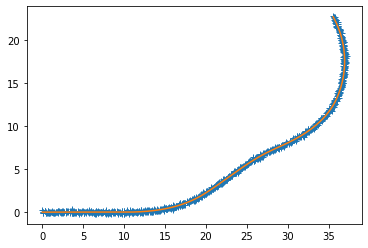

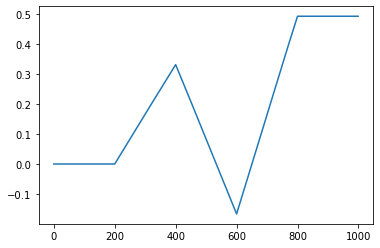

In [16]:
# X/Y positioning noise (normal distribution)
eta_x = np.random.normal(0, 0.1, N) 
eta_y = np.random.normal(0, 0.1, N) 

x_meas = eta_x + sim_results['x']
y_meas = eta_y + sim_results['y']
psi_meas = sim_results['psi']
psi_dot_meas = sim_results['psi_dot']
v_meas = sim_results['velocity']

plt.figure()
plt.plot(x_meas, y_meas, '+')
plt.plot(sim_results['x'], sim_results['y'])
plt.show()

plt.figure()
plt.plot(psi_dot_meas)
plt.show()

# Extended Kalman filter

The extended Kalman filter is applied to the linearized model descibed by the matrices $A_{dscr}$ and $B_{dscr}$ and given the system function $f_{dscr}$. The simulated data serves as measured data and is the input to the filter.

In [17]:
f_dscr

Matrix([
[T_s*v*cos(delta + psi) + x],
[T_s*v*sin(delta + psi) + y],
[T_s*v*sin(delta)/l_r + psi]])

In [18]:
A_dscr

Matrix([
[1, 0, -T_s*v*sin(delta + psi)],
[0, 1,  T_s*v*cos(delta + psi)],
[0, 0,                       1]])

In [19]:
B_dscr

Matrix([
[-T_s*v*sin(delta + psi), T_s*cos(delta + psi)],
[ T_s*v*cos(delta + psi), T_s*sin(delta + psi)],
[   T_s*v*cos(delta)/l_r,   T_s*sin(delta)/l_r]])

The implemented filter in form of a loop

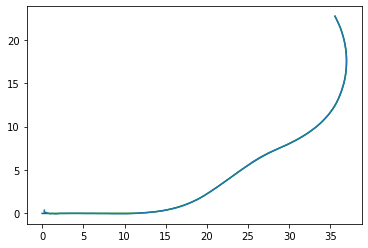

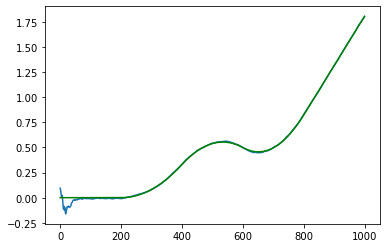

In [20]:
l_r = wheelbase

# allocate space to store the filter results
results = {'delta' : np.zeros(N), 'x' : np.zeros(N), 'y' : np.zeros(N), 'psi' : np.zeros(N) }

# the guess/estimate of the initial states
X = np.matrix([ [0.5], [0.5], [0.1] ])

P = np.matrix([  [0.1, 0,   0     ], 
                 [0,   0.1, 0     ],
                 [0,   0,   0.1   ]  ])

# covariance of the noise w addtitive to the states
Q = 0.00001*np.matrix([  [1, 0, 0 ], 
                         [0, 1, 0 ],
                         [0, 0, 1 ]  ])
 
# covariance of the noise v in the measured system output signal
R = np.matrix([  [0.1, 0   ], 
                 [0  , 0.1 ]  ])


for i in range(0,N):
    
    # measured input signals 
    v       = v_meas[i]
    x       = x_meas[i]
    y       = y_meas[i]
    psi_dot = psi_dot_meas[i]
    
    
    # compute steering angle by the inverse for the vehicle orientation change 
    delta = math.asin( psi_dot * l_r / v )
        
    # system output vector (x, y)
    z = np.matrix([ [x], [y] ])
    
    # pridiction step using the non-linear model (f_dscr) 
    # x(k-1|k-1) --> x(k|k-1)
    
    X[0] = X[0] + Ts * ( v * math.cos( X[2] + delta ) )
    X[1] = X[1] + Ts * ( v * math.sin( X[2] + delta ) )
    X[2] = X[2] + Ts * ( v / l_r * math.sin(delta) )
    
    # optionally use the auto-generated python function for evaluation
    # X = f_dscr_fn( Ts, l_r, float(X[0]), float(X[1]), float(X[2]), v, delta )

    # evaluate jacobi matrices A_dscr and B_dscr
    F = np.matrix([  [1, 0, -Ts*v*math.sin(delta+X[2])  ], 
                     [0, 1,  Ts*v*math.cos(delta+X[2])  ],
                     [0, 0, 1                           ]   ])
    
    # optionally use the auto-generated python function for evaluation
    # F = A_dscr_fn( Ts, l_r, float(X[0]), float(X[1]), float(X[2]), v, delta )
    
    
    B = np.matrix([  [-Ts*v*math.sin(delta+X[2]), Ts*math.cos(delta+X[2])      ], 
                     [ Ts*v*math.cos(delta+X[2]), Ts*math.sin(delta+X[2])      ],
                     [Ts*v/l_r * math.cos(delta), Ts/l_r * math.sin(delta)     ]   ])
    
    # optionally use the auto-generated python function for evaluation
    # B = B_dscr_fn( Ts, l_r, float(X[0]), float(X[1]), float(X[2]), v, delta )
    
    # the system output matrix: returns X and Y when multiplied with the state vector X
    # which are compared to the measurements
    H = np.matrix([  [1,0,0], 
                     [0,1,0] ])
    
    # prdicted state covariance P(k|k-1)
    P = F*P*F.transpose() + Q
    
    # estimation output residual vector
    e = z - H*X
        
    # Kalman gain
    S = H*P*H.transpose() + R
    K = P*H.transpose() * np.linalg.inv( S )
    
    # post priori state X(k|k)
    X = X + K*e
    
    # post priori covariance
    P = (np.eye(3) - K*H) * P

    
    
    # store results
    results['delta'][i] = delta
    results['x'][i] = X[0]
    results['y'][i] = X[1]
    results['psi'][i] = X[2]
    

# show results
plt.figure()
#plt.plot(x_meas, y_meas, '+')
plt.plot(sim_results['x'], sim_results['y'], 'g')
plt.plot(results['x'], results['y'])
plt.show()

plt.figure()
plt.plot(results['psi'])
plt.plot(sim_results['psi'], 'g')
plt.show()